/var/folders/gg/wqlmrvl91mj28lsltv0ccxqm0000gn/T/ipykernel_93006/1276746676.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_by_task_type.values, y=accuracy_by_task_type.index, palette='viridis')


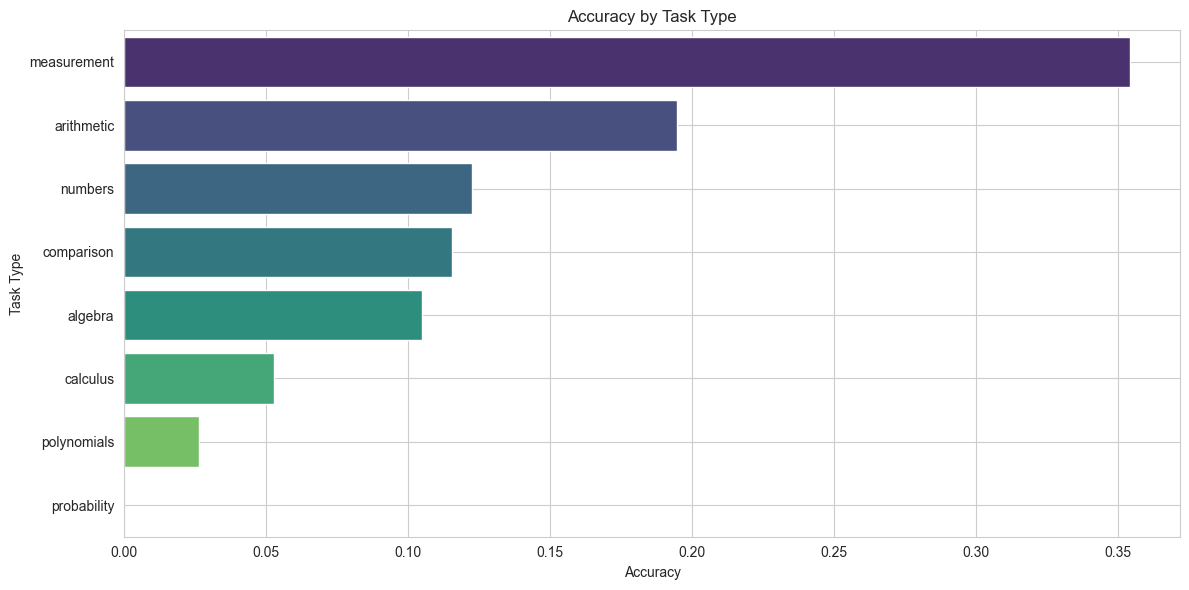

🔹 Общая точность: 12.19%
🔹 Число float-совпадений с неправильной маркировкой: 18
🔹 Число примеров без ответа: 0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../results/baseline/baseline_results.csv')  

df['task_type'] = df['file'].apply(lambda x: x.split('__')[0] if '__' in x else x.split('.')[0])


def try_parse_float(value):
    try:
        return float(value)
    except:
        return None

df['gt_float'] = df['gt_answer'].apply(try_parse_float)
df['llm_float'] = df['llm_answer'].apply(try_parse_float)


overall_accuracy = df['correct'].mean()


accuracy_by_task_type = df.groupby('task_type')['correct'].mean().sort_values(ascending=False)

float_match_errors = df[
    (~df['correct']) &
    (df['gt_float'].notna()) &
    (df['llm_float'].notna()) &
    (np.isclose(df['gt_float'], df['llm_float'], atol=1e-4))
]
num_float_match_errors = len(float_match_errors)

num_empty_answers = df['llm_answer'].isna().sum() + (df['llm_answer'].astype(str).str.strip() == '').sum()


plt.figure(figsize=(12, 6))
sns.barplot(x=accuracy_by_task_type.values, y=accuracy_by_task_type.index, palette='viridis')
plt.xlabel('Accuracy')
plt.ylabel('Task Type')
plt.title('Accuracy by Task Type')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'🔹 Общая точность: {overall_accuracy:.2%}')
print(f'🔹 Число float-совпадений с неправильной маркировкой: {num_float_match_errors}')
print(f'🔹 Число примеров без ответа: {num_empty_answers}')


In [21]:
import importlib.util
import sys
import os
import glob
import matplotlib.pyplot as plt

# Загрузка скрипта
script_path = "../eval_agent/get_error_statistic.py"
module_name = "get_error_statistic"

spec = importlib.util.spec_from_file_location(module_name, script_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)


In [22]:
# Параметры
folder = "../results/code_eval"
prefix = "train_"
pattern = os.path.join(folder, f"{prefix}*.json")
files = glob.glob(pattern)

print(f"🔍 Найдено файлов: {len(files)}")

# Сбор статистики по всем файлам
from collections import defaultdict

category_totals = defaultdict(lambda: defaultdict(int))

for filepath in files:
    stats, cuda_oom, too_many_steps, digits_error = module.analyze_file(filepath)
    for cat, data in stats.items():
        for key, value in data.items():
            category_totals[cat][key] += value


🔍 Найдено файлов: 4


/var/folders/gg/wqlmrvl91mj28lsltv0ccxqm0000gn/T/ipykernel_93006/3012145045.py:18: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) Arial.
  plt.tight_layout()
/Users/diana/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


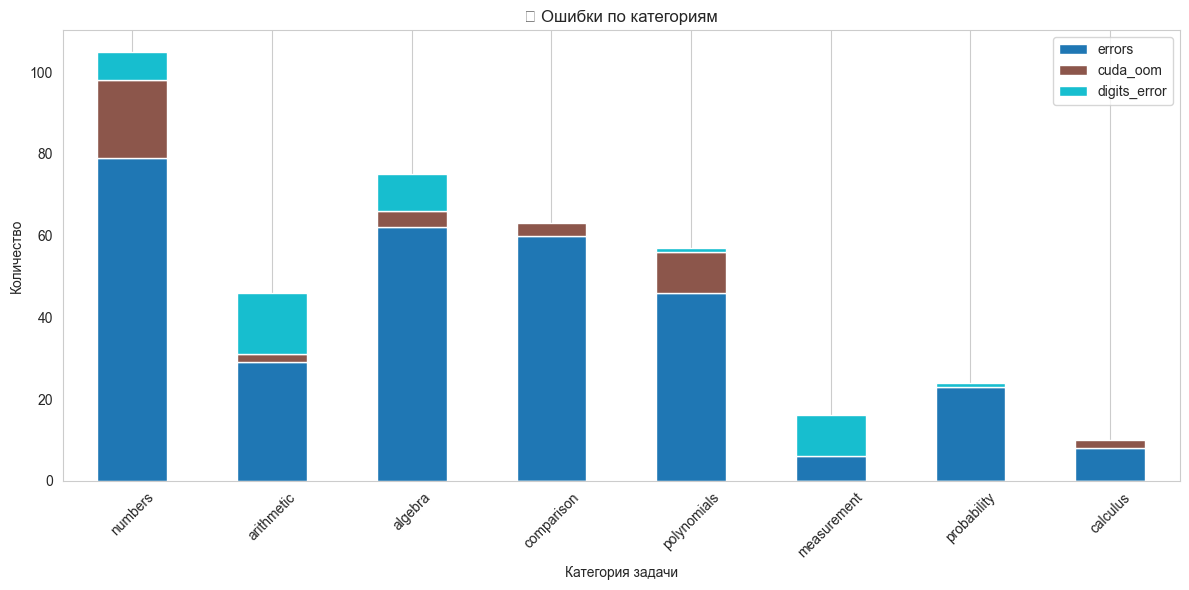

In [28]:
import pandas as pd

# Преобразование в DataFrame
df_stats = pd.DataFrame.from_dict(category_totals, orient='index')
df_stats = df_stats.sort_values('total', ascending=False)

# Столбчатые диаграммы
error_types = ['errors', 'cuda_oom', 'digits_error']
df_stats_plot = df_stats[error_types]

# Визуализация
df_stats_plot.plot(kind='bar', figsize=(12, 6), stacked=True, colormap='tab10')
plt.title("🧮 Ошибки по категориям")
plt.xlabel("Категория задачи")
plt.ylabel("Количество")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [30]:
# Подсчет суммарной статистики
total_tasks = df_stats['total'].sum()
total_correct = df_stats['total'].sum() - df_stats['errors'].sum()
total_correct_with_equiv = total_correct + df_stats['digits_error'].sum()

# Общая точность
accuracy = total_correct / total_tasks * 100
accuracy_with_equiv = total_correct_with_equiv / total_tasks * 100

print(f"✅ Всего задач: {total_tasks}")
print(f"✅ Правильных ответов: {total_correct} ({accuracy:.2f}%)")
print(f"✅ Правильных с учетом вариантов по типу 25.0 и 25: {total_correct_with_equiv} ({accuracy_with_equiv:.2f}%)")


✅ Всего задач: 672
✅ Правильных ответов: 359 (53.42%)
✅ Правильных с учетом вариантов по типу 25.0 и 25: 402 (59.82%)


In [31]:
import os, json
from math import isclose
from collections import defaultdict

def is_equivalent(a, b, tol=1e-6):
    try:
        return isclose(float(a), float(b), abs_tol=tol)
    except:
        return str(a).strip() == str(b).strip()


eval_folder = "../results/code_eval"
eval_files = glob.glob(os.path.join(eval_folder, "math_*.json"))

print(f"Found files: {len(eval_files)}")

# Статистика по всем файлам
overall_stats = defaultdict(int)

for file in eval_files:
    with open(file, "r") as f:
        data = json.load(f)
    
    stats = data.get("statistics", {})
    details = stats.get("details", [])

    overall_stats["total"] += stats.get("total", len(details))
    overall_stats["correct"] += stats.get("correct", 0)
    overall_stats["incorrect"] += stats.get("incorrect", 0)
    overall_stats["no_answer"] += stats.get("no_answer", 0)
    overall_stats["api_errors"] += stats.get("api_errors", 0)

    # Добавим "essentially correct"
    for item in details:
        expected = item.get("expected", "").strip()
        predicted = item.get("predicted", "").strip()
        verdict = item.get("verdict", "").upper()

        if verdict == "CORRECT":
            overall_stats["essentially_correct"] += 1
        elif is_equivalent(expected, predicted):
            overall_stats["essentially_correct"] += 1


Found files: 4


In [33]:
print("Statistic:")
for k, v in overall_stats.items():
    print(f"{k:25} {v}")


essentially_correct = overall_stats["essentially_correct"]
total = overall_stats["total"]
percent_correct = overall_stats["correct"] / total * 100
percent_essentially_correct = essentially_correct / total * 100

print(f"\n✅ Correct: {percent_correct:.2f}%")
print(f"✅ Essentially correct: {percent_essentially_correct:.2f}%")


Statistic:
total                     654
correct                   464
incorrect                 190
no_answer                 0
api_errors                0
essentially_correct       466

✅ Correct: 70.95%
✅ Essentially correct: 71.25%
